# Lesson 2: Computer Vision Fundamentals
## Submission, Markus Schwickert, 2018-02-22

### Video

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import *
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

%matplotlib inline
# Import everything needed to edit/save/watch video clips

In [8]:
def process_image(image):

    ysize = image.shape[0]
    xsize = image.shape[1]
    
    # future improvements: express masking regions as fraction of total dimension
    # -detect lines and adjust masks accordingly
    
    
    # switch parameters to challenge (1) or standard (0)
    challenge =0 
    
    if challenge ==1:
        # Masking coordinates
        vertical_bottom=655
        left_bottom = [150, vertical_bottom]
        right_bottom = [1200, vertical_bottom]
   
        xcenter=630 
        fphalfwidth=30
        vertical_cut=430
    
        # Define our color selection criteria
        red_threshold = 220
        green_threshold = 100
        blue_threshold = 30 
    
        # Define parameters for Canny
        low_threshold = 50
        high_threshold = 150
        kernel_size = 5

        #Hough Parameters
        threshold = 1
        min_line_length = 15
        max_line_gap = 20
   
    else:
        # Masking coordinates
        vertical_bottom=ysize
        left_bottom = [0, vertical_bottom]
        right_bottom = [xsize, vertical_bottom]
   
        xcenter=472
        fphalfwidth=22
        vertical_cut=325
    
        # Define our color selection criteria
        red_threshold = 180
        green_threshold = 180
        blue_threshold = 100
    
        # Define parameters for Canny
        low_threshold = 50
        high_threshold = 150
        kernel_size = 5

        #Hough Parameters
        threshold = 1
        min_line_length = 16
        max_line_gap = 20


    color_select = np.copy(image)

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Identify pixels below the threshold
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    
    gray = cv2.cvtColor(color_select, cv2.COLOR_RGB2GRAY) #grayscale conversion
    #plt.imshow(gray, cmap='gray')
    
    # Define a polygon region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

    fp1 = [xcenter-fphalfwidth, vertical_cut]
    fp2 = [xcenter+fphalfwidth, vertical_cut]

    mask = np.zeros_like(gray)   
    ignore_mask_color = 255 

    # This time we are defining a four sided polygon to mask
    vertices = np.array([[left_bottom, fp1, fp2, right_bottom]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    grayROI = cv2.bitwise_and(gray, mask)
    plt.imshow(grayROI)
    # Canny edge detection
    # Define a kernel size for Gaussian smoothing / blurring
    blur_gray = cv2.GaussianBlur(grayROI,(kernel_size, kernel_size), 0)
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Hough Transformation 
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank
  #  for line in lines:
  #      for x1,y1,x2,y2 in line:
  #          cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
  # Let's use a little gray matter here
  # 1) we sort the lines between left of center and right of center
  # 2) we create a point cloud with all x coordinates and the 
  #    corresponding y coordinates for each line
  # 3) we fit the y vs x for each side
  # 4) we draw one line left and right in the visible area
    
    xr=[]
    yr=[]
    xl=[]
    yl=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # let's just forget about the questionable cases
            if ((x1<xcenter)&(x2<xcenter)):
                for i in range (x1, x2):
                    xl.append(i)
                    yl.append((y2-y1)/(x2-x1)*(i-x1)+y1)
            if ((x1>xcenter)&(x2>xcenter)):
                for i in range (x1, x2):
                    xr.append(i)
                    yr.append((y2-y1)/(x2-x1)*(i-x1)+y1) 

    if (len(xr) >0):
        for i in range(len(xr)):
            cv2.circle(line_image, (int(xr[i]),int(yr[i])), 1, (0,20,255))
        mright, bright = np.polyfit(xr, yr, 1)
        xr_bottom=int((vertical_bottom-bright)/mright)
        xr_top=int((vertical_cut-bright)/mright)
        cv2.line(line_image,(xr_bottom,vertical_bottom),(xr_top,vertical_cut),(255,0,0),10)

    if (len(xl) >0):
        for i in range(len(xl)):
            cv2.circle(line_image, (int(xl[i]),int(yl[i])), 1, (0,255,0))           
        mleft, bleft = np.polyfit(xl, yl, 1)  # y = m*x + b   
        xl_bottom=int((vertical_bottom-bleft)/mleft)
        xl_top=int((vertical_cut-bleft)/mleft)
        cv2.line(line_image,(xl_bottom,vertical_bottom),(xl_top,vertical_cut),(255,0,0),10)

    # Create a "color" binary image to combine with line image

    # Draw the lines on the edge image
    combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    plt.imshow(combo)
   # mpimg.imsave('MS_images/'+ str(len(xr)*len(xl)+mright)+'.jpg', combo)
    return combo

[MoviePy] >>>> Building video MS_videos/solidWhiteRight_processed.mp4
[MoviePy] Writing video MS_videos/solidWhiteRight_processed.mp4


100%|█████████▉| 221/222 [00:09<00:00, 22.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: MS_videos/solidWhiteRight_processed.mp4 

CPU times: user 9.97 s, sys: 1.03 s, total: 11 s
Wall time: 10.2 s


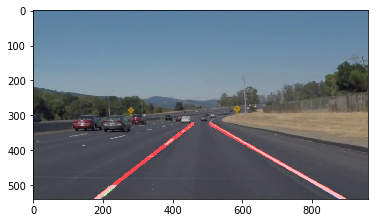

In [4]:
new_clip_output = 'MS_videos/solidWhiteRight_processed.mp4'
test_clip = VideoFileClip("test_videos/solidWhiteRight.mp4")

new_clip = test_clip.fl_image(process_image) 

%time new_clip.write_videofile(new_clip_output, audio=False)

In [5]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

[MoviePy] >>>> Building video MS_videos/solidYellowLeft_processed.mp4
[MoviePy] Writing video MS_videos/solidYellowLeft_processed.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: MS_videos/solidYellowLeft_processed.mp4 

CPU times: user 32.5 s, sys: 2.94 s, total: 35.5 s
Wall time: 32.3 s


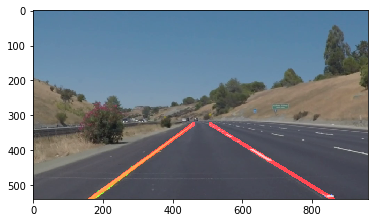

In [6]:
new_clip_output = 'MS_videos/solidYellowLeft_processed.mp4'
test_clip = VideoFileClip("test_videos/solidYellowLeft.mp4")
new_clip = test_clip.fl_image(process_image) 

%time new_clip.write_videofile(new_clip_output, audio=False)


In [7]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

# Challenge

[MoviePy] >>>> Building video MS_videos/challenge_processed.mp4
[MoviePy] Writing video MS_videos/challenge_processed.mp4


100%|██████████| 251/251 [00:19<00:00, 12.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: MS_videos/challenge_processed.mp4 

CPU times: user 18.8 s, sys: 2.19 s, total: 21 s
Wall time: 20.4 s


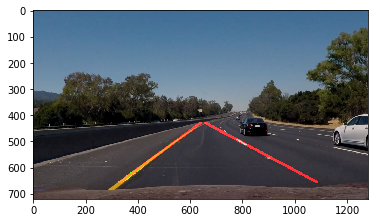

In [9]:
new_clip_output = 'MS_videos/challenge_processed.mp4'
test_clip = VideoFileClip("test_videos/challenge.mp4")
new_clip = test_clip.fl_image(process_image) 

%time new_clip.write_videofile(new_clip_output, audio=False)

# Don't forget to set the challenge paramter to 1 in the DEF

In [10]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

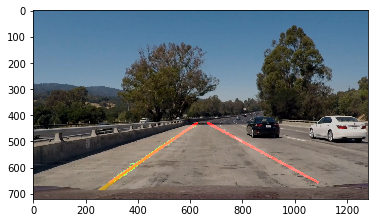

In [55]:
#single image processing with the DEF

image = mpimg.imread('challenge2.jpg')
plt.imshow(process_image(image))
